# operation for "AllPoints"

In [1]:
import pandas as pd
import numpy as np
import os, glob
from sklearn.utils import shuffle
import random
import math

In [2]:
path = '/Users/lipeijia/AllPoints'

In [3]:
file = glob.glob(os.path.join(path, "*.csv"))

dl = []
for f in file:
    dl.append(pd.read_csv(f, index_col=None))

dataset = pd.concat(dl)

# shuffle dataset
random.seed(1)
dataset = shuffle(dataset)

# remove useless features
dataset = dataset.drop(dataset.columns[[0]], axis=1)
idx = ['DemDiff_Swath', 'DemDiffMad_Swath', 'DemDiff_SwathOverPoca', 'MeanDiffSpread_Swath']
dataset = dataset.drop(columns=idx)

# split into features and labels
dataset_X = dataset.drop(['Elev_Oib', 'Elev_Swath'], axis=1)
dataset_Y = dataset.apply(lambda x: x['Elev_Oib'] - x['Elev_Swath'], axis=1)
# dataset_Y = pd.DataFrame(dataset_Y)

In [5]:
cut = math.ceil(dataset.shape[0]*0.95)
train_x = dataset_X[:cut]
train_y = dataset_Y[:cut]
test_x = dataset_X[cut:]
test_y = dataset_Y[cut:]

In [6]:
print(train_x.shape, test_x.shape)

(1055826, 22) (55569, 22)


## Exploratory Data Analysis

In [7]:
idx = ['PowerWatt_Swath', 'Lat_Swath', 'Lon_Swath', 'X_Swath', 'Y_Swath',
           'StartTime_Swath', 'Wf_Number_Swath']
train_x = train_x.drop(columns=idx)
test_x = test_x.drop(columns=idx)

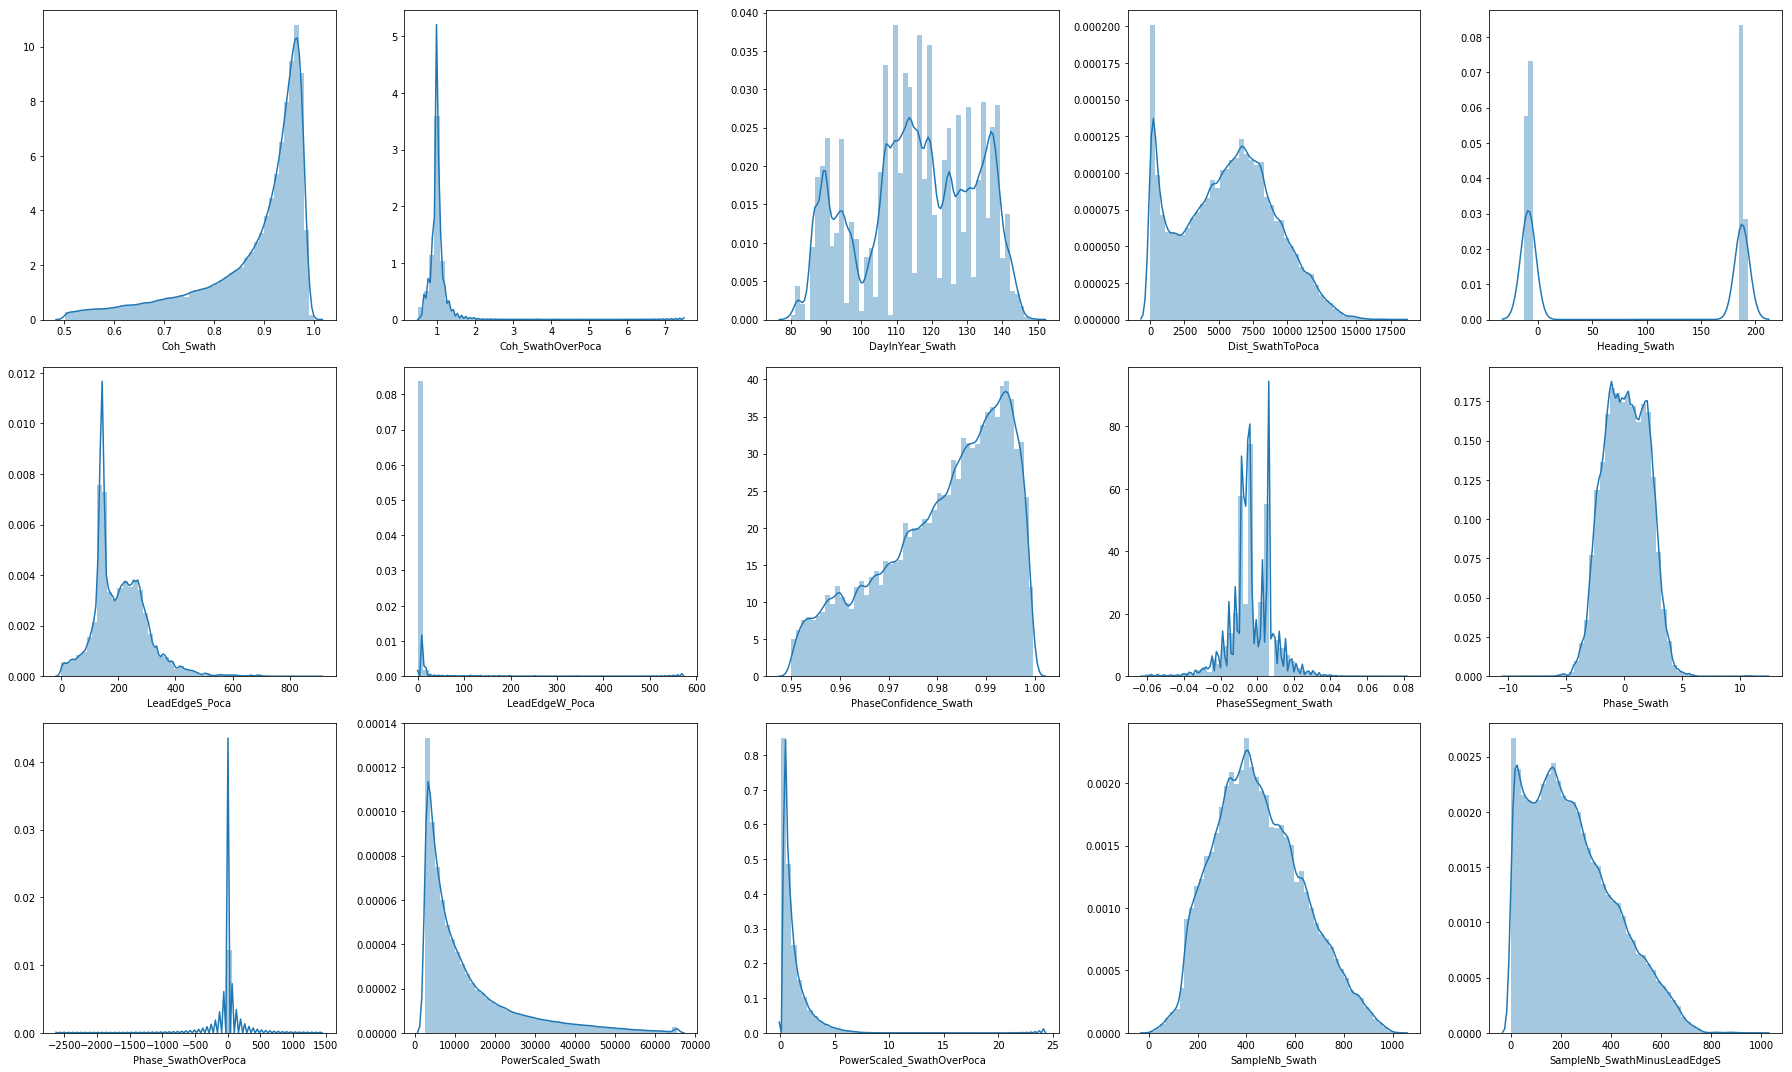

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
variable_names = np.asarray(train_x.columns.values.tolist()).reshape(3, 5)
fig, ax = plt.subplots(3, 5, figsize=(25, 15))
for ii in range(3):
    for jj in range(5):
        var = variable_names[ii][jj]
        sns.distplot(train_x[var], ax=ax[ii][jj], kde=True)
        ax[ii][jj].xaxis.label.set_visible(True)
fig.tight_layout()
plt.show()

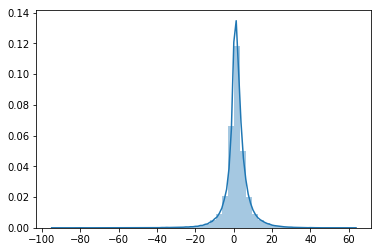

In [10]:
sns.distplot(train_y)

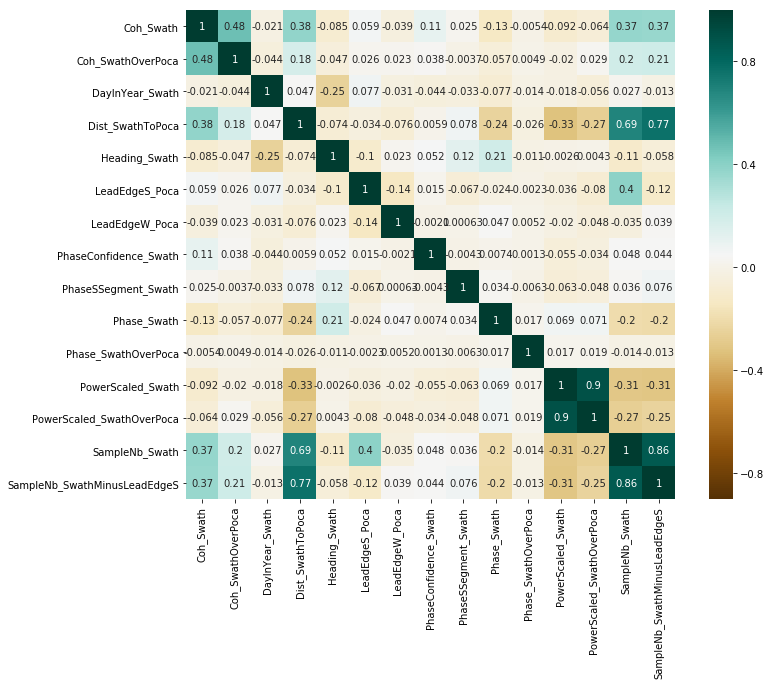

In [11]:
cormat = train_x.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, square=True, vmin=-0.9, vmax=1.0, annot=True, cmap="BrBG")
plt.show()

In [8]:
from sklearn import preprocessing
from scipy.stats import skew
train_fe = train_x.copy()
test_fe = test_x.copy()

In [9]:
train_fe['Heading_Swath'][train_fe['Heading_Swath'] < 100] = 0
train_fe['Heading_Swath'][train_fe['Heading_Swath'] >= 100] = 1
test_fe['Heading_Swath'][test_fe['Heading_Swath'] < 100] = 0
test_fe['Heading_Swath'][test_fe['Heading_Swath'] >= 100] = 1

/Users/lipeijia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lipeijia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lipeijia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing 

In [10]:
skewness = train_fe.apply(lambda x: skew(x))
skewness_features = skewness[np.abs(skewness >= 0.75)].index
train_fe[skewness_features] = np.log1p(train_fe[skewness_features])
test_fe[skewness_features] = np.log1p(test_fe[skewness_features])

index1 = np.asarray(train_fe.columns.values.tolist())
index1 = ['Coh_Swath', 'Coh_SwathOverPoca', 'DayInYear_Swath',
       'Dist_SwathToPoca', 'LeadEdgeS_Poca',
       'LeadEdgeW_Poca', 'PhaseConfidence_Swath', 'PhaseSSegment_Swath',
       'Phase_Swath', 'Phase_SwathOverPoca', 'PowerScaled_Swath',
       'PowerScaled_SwathOverPoca', 'SampleNb_Swath',
       'SampleNb_SwathMinusLeadEdgeS']
for i in index1:
    train_fe[i] = (train_fe[i]-np.mean(train_fe[i]))/np.std(train_fe[i])
    test_fe[i] = (test_fe[i] - np.mean(test_fe[i]))/np.std(test_fe[i])

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(train_fe, train_y)
pred_y_reg_train = reg.predict(train_fe)
pred_y_reg = reg.predict(test_fe)
rmse_reg_trian = np.sqrt(mean_squared_error(train_y, pred_y_reg_train))
rmse_reg = np.sqrt(mean_squared_error(test_y, pred_y_reg))
print(rmse_reg_trian, rmse_reg)

6.424615684799131 6.3164044172529765


In [16]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
svr = SVR(kernel='rbf', C=100, gamma=0.0008,epsilon=0.001)
fit = svr.fit(train_fe, train_y)
pred = fit.predict(train_fe)
pred_test = fit.predict(test_fe)
rmse_trian = np.sqrt(mean_squared_error(pred, train_y))
rmse_test = np.sqrt(mean_squared_error(pred_test, test_y))
print(rmse_trian, rmse_test)

In [14]:
from xgboost import XGBRegressor
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
xgb = XGBRegressor(learning_rate=0.1,
                   n_estimators=600,
                   max_depth=10,
                   min_child_weight=1,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   gamma=0.2,
                   reg_alpha=2,
                   reg_lambda=1).fit(train_fe, train_y)
pred_y_train = xgb.predict(train_fe)
pred_y = xgb.predict(test_fe)
rmse_xgb_train = np.sqrt(mean_squared_error(train_y, pred_y_train))
rmse_xgb = np.sqrt(mean_squared_error(test_y, pred_y))
print(rmse_xgb_train,rmse_xgb)

/Users/lipeijia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/lipeijia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:50:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1.5004562572086155 2.6290772203872828


In [17]:
import torch
import torch.nn as nn

In [18]:
n_features = train_fe.shape[1]
train_X = torch.tensor(train_fe.values,
                       dtype=torch.float)
train_Y = torch.tensor(train_y.values, dtype=torch.float)
train_Y = torch.unsqueeze(train_Y, dim=1)

In [19]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(15, 60)
        self.fc2 = nn.Linear(60, 120)
        self.fc3 = nn.Linear(120, 30)
        self.out = nn.Linear(30, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.out(x)
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=15, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()

for step in range(5000):
    pred = net(train_X)
    loss = loss_function(pred, train_Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(loss)

tensor(16.2630, grad_fn=<MseLossBackward>)


In [21]:
test_XX = torch.tensor(test_fe.values, dtype=torch.float)
prediction = net(test_XX)
test_YY = torch.tensor(test_y.values, dtype=torch.float)
cost = loss_function(prediction, test_YY)
cost

/Users/lipeijia/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([55569])) that is different to the input size (torch.Size([55569, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(66.3057, grad_fn=<MseLossBackward>)

In [24]:
print(torch.sqrt(loss))

tensor(4.0327, grad_fn=<SqrtBackward>)


In [25]:
torch.sqrt(cost)

tensor(8.1428, grad_fn=<SqrtBackward>)